<img src="img/GraphAISummitNEW.png" alt="Drawing" width="1000" height="100"/>

# Alex Infanzon & Bob Hardaway<br>
## Professional Sales Engineers, Ametuer Data Scientists<br>
## Intro to Recommendations with Tigergraph, Docker and Python<br>

In the next 40 minutes, we will introduce the PyTigerGraph python package and
develop a simple recommendation engine running on a portable Docker container.


# pyTigerGraph examples

TigerGraph is a graph database software with a multitude of functionality and solutions to some of the issues that have plagued other graph databases. This notebook demonstrates how to use basic commands to connect, create and load data into TigerGraph using the Python pyTigerGraph module.

<img src="img/Architecture_diagram.png" alt="Drawing" width="1000" height="100"/>

## STEP 1: Import Packages

Note: Assuming you have installed the pyTigerGraph package. If not install it using:
```pip install pyTigerGraph```

In [2]:
import pyTigerGraph as tg
import pandas as pd
import json
import re
from IPython.display import display
from PIL import Image

print(tg.__version__)

0.0.9.7.3


In [ ]:
## Make sure to keep packages up to date

#pip install -U pyTigerGraph pyTigerDriver

## STEP 2: Establishing the connection to a TigerGraph database

<div>
  <img style="vertical-align:top" src="img/connected-icon.png" width="30" height="30"/>
  <span style="">The functionality of pyTigerGraph is implemented by the TigerGraphConnection class. To establish the connection to the database you need to provide the hostname, username and password to access the database.</span>
</div>


<table>
  <tr>
    <th>Connect to localhost</th>
    <th>Connect to TG Cloud</th>
    <th>Connect to AWS EC2 Container</th>
  </tr>
  <tr>
    <td>conn = tg.TigerGraphConnection(<br>host='http://localhost',<br> username="tigergraph",<br> password='tigergraph'<br>) </td>
    <td>conn = tg.TigerGraphConnection(<br>host='https://tgcloud.io/app/solutions',<br> graphname="test",<br> username=userName,<br> password=password,<br> apiToken=apiToken)<br> authToken = conn.getToken(secret)<br> )</td>
    <td>conn = tg.TigerGraphConnection(<br>host='http://ec2-52-44-226-118.compute-1.amazonaws.com',<br> graphname="test",<br> username=userName,<br> password=password,<br> apiToken=apiToken)<br> authToken = conn.getToken(secret)<br> )</td>
   </tr>

</table>

In [3]:
conn = tg.TigerGraphConnection(
    host='http://ec2-52-44-226-118.compute-1.amazonaws.com',
    username="tigergraph",
    password='tigergraph')

## STEP 3: Design Schema

<div>
  <img style="vertical-align:top" src="img/graph_img.png" width="30" height="30"/>
  <span style="">Before data can be loaded into the graph store, the user must define a graph schema. A graph schema is a "dictionary" that defines the types of entities, vertices and edges, in the graph and how those types of entities are related to one another.</span>
</div>

### WARNING: DROP ALL - Will Delete everything in your graph!

Execute this cell if you would like to start the notebook lab from the beginning.

In [4]:
print(conn.gsql('''DROP ALL''', options=[]))

Dropping all, about 1 minute ...
Abort all active loading jobs
Try to abort all loading jobs on graph EDMMembership, it may take a while ...
[ABORT_SUCCESS] No active Loading Job to abort.
Try to abort all loading jobs on graph Recommendations, it may take a while ...
[ABORT_SUCCESS] No active Loading Job to abort.
Resetting GPE...
Successfully reset GPE
Stopping GPE GSE
Successfully stopped GPE GSE in 5.069 seconds
Clearing graph store...
Successfully cleared graph store
Starting GPE GSE RESTPP
Successfully started GPE GSE RESTPP in 0.076 seconds
Everything is dropped.


----
<img src="img/graph_sch.png" alt="Drawing" width="500" height="100"/>

The CREATE VERTEX statement defines a new global vertex type, with a name and an attribute list. 

The CREATE EDGE statement defines a new global edge type. There are two forms of the CREATE EDGE statement, one for directed edges and one for undirected edges.  Each edge type must specify that it connects FROM one vertex type TO another vertex type.

In [5]:
print(conn.gsql('''

CREATE VERTEX person (PRIMARY_ID name STRING, gender STRING, name STRING, age INT, state STRING) 

CREATE UNDIRECTED EDGE friendship (FROM person, TO person, connect_day datetime)

CREATE GRAPH social (person, friendship)'''
                
, options=[]))

The vertex type person is created.
The edge type friendship is created.
Stopping GPE GSE RESTPP
Successfully stopped GPE GSE RESTPP in 1.259 seconds
Starting GPE GSE RESTPP
Successfully started GPE GSE RESTPP in 0.065 seconds
The graph social is created.


----
The GSQL command enable sending arbitrary GSQL statements to the database. Next cell show how to test the schema createtion was succesful.
Change to the social graph

In [6]:
conn.graphname = 'social'

## STEP 4: Load data

<div>
  <img style="vertical-align:top" src="img/load_data.png" width="30" height="30"/>
  <span style="">The pyTigerGraph submodule provides results from various built-in endpoints in a Pandas DataFrame. To load data upload the csv file to a dataframe inside the notebook. 
</span>
</div>

In [7]:
people = pd.read_csv('data/people.csv')
people

,id,name,gender,age,state
0,1,Tom,male,40,english
1,2,Dan,male,34,russian
2,3,Jenny,female,25,english
3,4,Kevin,male,28,dutch
4,5,Emily,female,22,spanish
5,6,Nancy,female,20,spanish
6,7,Jack,male,26,english
7,8,Bob,male,52,english
8,9,Alex,male,52,spanish
9,10,Margie,female,53,english


In [8]:
friendships = pd.read_csv('./data/friendships.csv')
friendships

,person1,person2,date
0,Tom,Dan,2017-06-03
1,Tom,Jenny,2015-01-01
2,Dan,Jenny,2016-08-03
3,Jenny,Amily,2015-06-08
4,Dan,Nancy,2016-01-03
5,Nancy,Jack,2017-03-02
6,Dan,Kevin,2015-12-30
7,Bob,Margie,1998-10-22
8,Lacy,Bob,2004-01-21
9,Margie,Lacy,1992-12-02


In [9]:
v_person = conn.upsertVertexDataFrame(
      people, "person", "name"
    , attributes={"name": "name", "gender": "gender", "age": "age", "state": "state"})
print(str(v_person) + " Customer VERTICES Upserted")

11 Customer VERTICES Upserted


In [10]:
numPersons = conn.getVertexCount("person")
print(f"There are currently {numPersons} in of vertex type person, prior to map")

There are currently 11 in of vertex type person, prior to map


In [11]:
v_friendships = conn.upsertEdgeDataFrame(friendships,"person", "friendship", "person", from_id="person1", to_id="person2", attributes={"connect_day":"date"})
print(str(v_friendships) + " Friendships Edges Upserted")

10 Friendships Edges Upserted


## STEP 5: Explore Graph

### The Functions

The functions below are grouped by:

- Schema related functions - these functions can be used to get schema information or to load data into the graph
- Query related functions - these two functions are use to run or compile GSQL queries
- Vertex related functions - vertex related functions
- Edge related functions - edge related functions
- Token management - management
- Other functions - some miselaneous functions


| Schema related functions | Query related functions | Vertex related functions | Edge related functions | Token management | Other functions |
| :------------------------| :---------------------- | :----------------------- | :--------------------- | :--------------- | :-------------- |
| getSchema | runInstalledQuery | getVertexTypes | getEdgeTypes | getToken | echo |
| getUDTs | runInterpretedQuery | getVertexType | getEdgeType | refreshToken  | getEndpoints|
| getUDT | | getVertexCount| getEdgeCount|deleteToken | getStatistics |
| upsertData| |  upsertVertex|upsertEdge||getVersion |
| | | upsertVertices | upsertEdges||getVer |
| | | getVertices | getEdges||getLicenseInfo |
| | | getVerticesById | getEdgeStats|| |
| | | getVertexStats | delEdges|||
| | | delVertices| | |
| | | delVerticesById| 

### A simple 'ls' command provides a complete summary of the TigerGraph elements.

In [12]:
print(conn.gsql('''ls''', options=[]))

---- Global vertices, edges, and all graphs
Vertex Types:
- VERTEX person(PRIMARY_ID name STRING, gender STRING, name STRING, age INT, state STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE"
Edge Types:
- UNDIRECTED EDGE friendship(FROM person, TO person, connect_day DATETIME)

Graphs:
- Graph social(person:v, friendship:e)
Jobs:


JSON API version: v2
Syntax version: v1



In [13]:
conn.getVertexTypes()

['person']

In [14]:
conn.getVertexType('person')

{'Config': {'TAGGABLE': False,
  'STATS': 'OUTDEGREE_BY_EDGETYPE',
  'PRIMARY_ID_AS_ATTRIBUTE': False},
 'Attributes': [{'AttributeType': {'Name': 'STRING'},
   'IsPartOfCompositeKey': False,
   'PrimaryIdAsAttribute': False,
   'AttributeName': 'gender',
   'HasIndex': False,
   'internalAttribute': False,
   'IsPrimaryKey': False},
  {'AttributeType': {'Name': 'STRING'},
   'IsPartOfCompositeKey': False,
   'PrimaryIdAsAttribute': False,
   'AttributeName': 'name',
   'HasIndex': False,
   'internalAttribute': False,
   'IsPrimaryKey': False},
  {'AttributeType': {'Name': 'INT'},
   'IsPartOfCompositeKey': False,
   'PrimaryIdAsAttribute': False,
   'AttributeName': 'age',
   'HasIndex': False,
   'internalAttribute': False,
   'IsPrimaryKey': False},
  {'AttributeType': {'Name': 'STRING'},
   'IsPartOfCompositeKey': False,
   'PrimaryIdAsAttribute': False,
   'AttributeName': 'state',
   'HasIndex': False,
   'internalAttribute': False,
   'IsPrimaryKey': False}],
 'PrimaryId': {'At

In [15]:
conn.getVertexStats('person')

{'person': {'age': {'MAX': 53, 'MIN': 0, 'AVG': 31.66667}}}

In [16]:
conn.getEdgeTypes()

['friendship']

In [17]:
conn.getEdgeStats('friendship', skipNA=False)

{'friendship': {'connect_day': {'MAX': 1496448000,
   'MIN': 723254400,
   'AVG': 1291896000}}}

## STEP 6: Write Queries

<div>
  <img style="vertical-align:top" src="img/query.png" width="28" height="28"/>
  <span style="">TBD. 
</span>
</div>

  from_type from_id to_type  to_id          connect_day
0    person   Jenny  person  Amily  2015-06-08 00:00:00
1    person   Jenny  person    Tom  2015-01-01 00:00:00
2    person   Jenny  person    Dan  2016-08-03 00:00:00


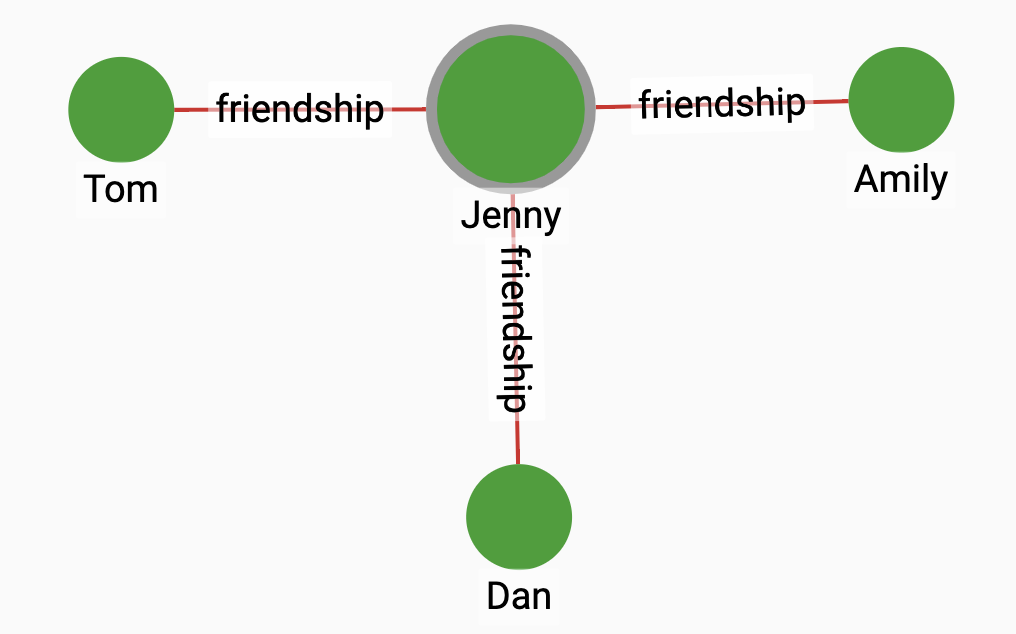

In [18]:
print(conn.getEdgesDataframe("person", "Jenny"))
display(Image.open("img/Explore_fig1.png"))

In [19]:
print(conn.gsql('''USE GRAPH social
   SELECT * FROM person LIMIT 3
'''))


Using graph 'social'
[
{
"v_id": "Emily",
"attributes": {
"gender": "female",
"name": "Emily",
"state": "spanish",
"age": 22
},
"v_type": "person"
},
{
"v_id": "Nancy",
"attributes": {
"gender": "female",
"name": "Nancy",
"state": "spanish",
"age": 20
},
"v_type": "person"
},
{
"v_id": "Jenny",
"attributes": {
"gender": "female",
"name": "Jenny",
"state": "english",
"age": 25
},
"v_type": "person"
}
]


In [20]:
conn.runInterpretedQuery('''INTERPRET QUERY () FOR GRAPH social {
    users = {person.*};
    Result = SELECT p FROM users:u-(friendship)->:p WHERE u.name == "Tom";
  PRINT Result; 
}''')

[{'Result': [{'v_id': 'Dan',
    'v_type': 'person',
    'attributes': {'gender': 'male',
     'name': 'Dan',
     'age': 34,
     'state': 'russian'}},
   {'v_id': 'Jenny',
    'v_type': 'person',
    'attributes': {'gender': 'female',
     'name': 'Jenny',
     'age': 25,
     'state': 'english'}}]}]

In [21]:
print(conn.gsql('''USE GRAPH social
   SELECT * FROM person WHERE gender=="female"'''))

Using graph 'social'
[
{
"v_id": "Emily",
"attributes": {
"gender": "female",
"name": "Emily",
"state": "spanish",
"age": 22
},
"v_type": "person"
},
{
"v_id": "Nancy",
"attributes": {
"gender": "female",
"name": "Nancy",
"state": "spanish",
"age": 20
},
"v_type": "person"
},
{
"v_id": "Jenny",
"attributes": {
"gender": "female",
"name": "Jenny",
"state": "english",
"age": 25
},
"v_type": "person"
},
{
"v_id": "Margie",
"attributes": {
"gender": "female",
"name": "Margie",
"state": "english",
"age": 53
},
"v_type": "person"
},
{
"v_id": "Lacy",
"attributes": {
"gender": "female",
"name": "Lacy",
"state": "spanish",
"age": 28
},
"v_type": "person"
}
]


### Use the built in gewtVertices() fucntion to return individual attributes for all females

In [22]:
res=conn.getVertices('person', select='name,age,gender', where='gender=="female"')
res

[{'v_id': 'Emily',
  'v_type': 'person',
  'attributes': {'name': 'Emily', 'age': 22, 'gender': 'female'}},
 {'v_id': 'Nancy',
  'v_type': 'person',
  'attributes': {'name': 'Nancy', 'age': 20, 'gender': 'female'}},
 {'v_id': 'Jenny',
  'v_type': 'person',
  'attributes': {'name': 'Jenny', 'age': 25, 'gender': 'female'}},
 {'v_id': 'Margie',
  'v_type': 'person',
  'attributes': {'name': 'Margie', 'age': 53, 'gender': 'female'}},
 {'v_id': 'Lacy',
  'v_type': 'person',
  'attributes': {'name': 'Lacy', 'age': 28, 'gender': 'female'}}]

### Retrive the individual attributes for each person, in order to create a feature matrix

In [23]:
attrs=[x['attributes'] for x in res]
attrs

[{'name': 'Emily', 'age': 22, 'gender': 'female'},
 {'name': 'Nancy', 'age': 20, 'gender': 'female'},
 {'name': 'Jenny', 'age': 25, 'gender': 'female'},
 {'name': 'Margie', 'age': 53, 'gender': 'female'},
 {'name': 'Lacy', 'age': 28, 'gender': 'female'}]

### Use the PAI to retrieve Dan's friends

In [24]:
sourceVertexType='person'
sourceVertexId='Dan'
conn.getEdges(sourceVertexType, sourceVertexId, edgeType=None, targetVertexType=None, targetVertexId=None, select="", where="", limit="", sort="", timeout=0)

[{'e_type': 'friendship',
  'directed': False,
  'from_id': 'Dan',
  'from_type': 'person',
  'to_id': 'Tom',
  'to_type': 'person',
  'attributes': {'connect_day': '2017-06-03 00:00:00'}},
 {'e_type': 'friendship',
  'directed': False,
  'from_id': 'Dan',
  'from_type': 'person',
  'to_id': 'Kevin',
  'to_type': 'person',
  'attributes': {'connect_day': '2015-12-30 00:00:00'}},
 {'e_type': 'friendship',
  'directed': False,
  'from_id': 'Dan',
  'from_type': 'person',
  'to_id': 'Jenny',
  'to_type': 'person',
  'attributes': {'connect_day': '2016-08-03 00:00:00'}},
 {'e_type': 'friendship',
  'directed': False,
  'from_id': 'Dan',
  'from_type': 'person',
  'to_id': 'Nancy',
  'to_type': 'person',
  'attributes': {'connect_day': '2016-01-03 00:00:00'}}]

In [25]:
attrs=res[-2]['attributes']
attrs

{'name': 'Margie', 'age': 53, 'gender': 'female'}

### Create a pandas dataframe base don the list returned from TigerGraph

In [26]:
df = pd.DataFrame(res)
df

,v_id,v_type,attributes
0,Emily,person,"{'name': 'Emily', 'age': 22, 'gender': 'female'}"
1,Nancy,person,"{'name': 'Nancy', 'age': 20, 'gender': 'female'}"
2,Jenny,person,"{'name': 'Jenny', 'age': 25, 'gender': 'female'}"
3,Margie,person,"{'name': 'Margie', 'age': 53, 'gender': 'female'}"
4,Lacy,person,"{'name': 'Lacy', 'age': 28, 'gender': 'female'}"


### You can also directly execute a query via the connection

In [27]:
conn.gsql('''use graph socselect * from person where primary_id=="Tom"''')

"Error: Currently not using any graphs! Please use 'USE GRAPH' command to switch to a graph. Create a graph if no graph exists."

### The power of Tiger is then to begin to traverse relationships in the data, such as retrieving all friends of Dan's friends

In [ ]:
conn.runInterpretedQuery('''
  INTERPRET QUERY x() FOR GRAPH social {
  # declaration statements
  STRING uid = "Tom";
  users = {person.*};
  # body statements
  posts = SELECT p
    FROM users:u-(friendship)->:p
    WHERE u.name == uid;
  PRINT posts; 
}
''')

In [ ]:
conn.runInterpretedQuery('''
  INTERPRET QUERY () FOR GRAPH social {
    person1 = {person.*};
    Result = SELECT tgt
           FROM person1:s-(friendship:e)-person:tgt;
    PRINT Result; 
}
''')

### Dive deeper into the network....

In [ ]:
conn.getEdges('person', 'Jenny'
              , edgeType='friendship'
              , targetVertexType='person'
              , targetVertexId=None, select="connect_day", where="", limit="", sort="", timeout=0)